In [2]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/sdtool_load_test/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.casedeck import*
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.selectors import *
# from hermes3.balance1d import *

# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


In [3]:
db = CaseDB(case_dir = '/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/Mike_2D_cases/m4ab-tune_albedo_new_branch', grid_dir='/users/jlb647/scratch/simulation_program/hermes-3_sim/sdtool_load_test/grids')

case = db.load_case_2D("m4ab-tune_albedo_new_branch", use_squash = True, verbose = True)

print(case.ds['dr'])



- Reading case m4ab-tune_albedo_new_branch
-----------------------
- Looking for squash file
- Squash file found. squash date 01/12/2025, 17:02:45, dmp file date 01/12/2025, 16:40:35

Unnormalising with xHermes
<xarray.DataArray 'dr' (x: 40, theta: 108)>
dask.array<truediv, shape=(40, 108), dtype=float64, chunksize=(40, 108), chunktype=numpy.ndarray>
Coordinates: (12/23)
    dx                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    dy                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    dz                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    zShift                   (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    psi_poloidal             (x, theta) float64 -0.001427 -0.001427 ... 0.00634
    R                        (x, theta) float64 0.3369 0.348 ... 1.513 1.524
    ...                       ...
    Zxy_upper_left_corners   (x, theta) float64

In [4]:
case.ds["da_test"] = case.ds['dx']*case.ds['dx'].conversion* case.ds['J']*case.ds['J'].conversion / np.sqrt(case.ds['g_22'])


dx_conv = case.ds['dx'].conversion
J_conv = case.ds['J'].conversion



print(case.ds['dz'].values)


J = case.ds["J"]    
g_22 = case.ds["g_22"] 
dx = case.ds["dx"]    

# para face area
A_parallel = J * (g_22**0.5) * dx





case.ds["A_parallel"] = A_parallel


# print(A_parallel.values)


[[6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]
 ...
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]]


1 None
i vs e heatlfux ratio at xpoint =  0.40432503915067813


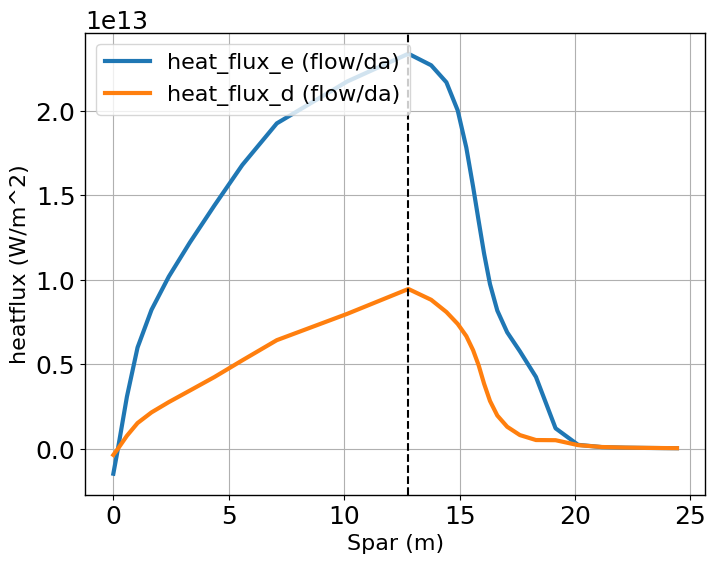

In [5]:

params = ['R', 'Bxy', 'efd+_cond_ylow', 'efd+_kin_ylow', 'efd+_tot_xlow', 'efd+_tot_ylow', 
          'efe_cond_ylow' , 'efe_kin_ylow', 'efe_tot_ylow', 'kappa_par_e', 'Te', 
          'efd+_tot_xlow','efe_tot_xlow', 'J', 'g_22', 'dx', 'dy','dz', 'Td+', 'dr']
profile = get_1d_poloidal_data(case.ds.isel(t=-1), params = params, region = ('outer_lower'), sepadd = 1)

# da = profile['J']*profile['dx']*profile['dz']/np.sqrt(profile['g_22'])

dx_conv = case.ds['dx'].conversion

da = profile['dx']*profile['dz']*dx_conv*profile['J']/np.sqrt(profile['g_22'])
dr = profile['dr']



# heat_flux_e = profile['efe_tot_ylow']*da
# heat_flux_d = profile['efd+_tot_ylow']*da

heat_flux_e = profile['efe_tot_ylow']/da
heat_flux_d = profile['efd+_tot_ylow']/da


# heat_flux_e = profile['efe_tot_ylow']/dr
# heat_flux_d = profile['efd+_tot_ylow']/dr


norm_e = heat_flux_e/np.max(heat_flux_e)
norm_d = heat_flux_d/np.max(heat_flux_e)

xpoint_loc = np.argmin(np.abs(profile['R']))
# print(xpoint_loc)


print('i vs e heatlfux ratio at xpoint = ', heat_flux_d[xpoint_loc]/heat_flux_e[xpoint_loc])

# print(np.max(heat_flux_e))

spar = profile['Spar']


q_par_e = -1* profile['kappa_par_e']*np.gradient(profile['Te'], spar)

fig,ax = plt.subplots(1,1, figsize = (8,6))
# ax.plot(profile['Spol'], profile['efd+_tot_ylow'], label = 'efd+_tot_ylow', linewidth = linewidth)
# ax.plot(profile['Spol'], profile['efe_tot_ylow'], label = 'efe_tot_ylow', linewidth = linewidth)
ax.plot(spar, heat_flux_e, label = 'heat_flux_e (flow/da)', linewidth = linewidth)
ax.plot(spar, heat_flux_d, label = 'heat_flux_d (flow/da)', linewidth = linewidth)

# ax.plot(spar, norm_e, label = 'heat_flux_e/max(heatflux_e)', linewidth = linewidth)
# ax.plot(spar, norm_d, label = 'heat_flux_d+/max(heatflux_e)', linewidth = linewidth)
ax.axvline(spar[xpoint_loc], color = 'black', linestyle = '--')

# ax.plot(spar, q_par_e, label = 'q_par_e (spitzer)', linewidth = linewidth)
# print(profile['Spar'])

ax.set_xlabel('Spar (m)')
ax.set_ylabel('heatflux (W/m^2)')
ax.legend()
# ax.set_yscale('log')
# ax.plot(profile['Spol'], q_par_e, label = 'q_par_e', linewidth = linewidth)
ax.legend()

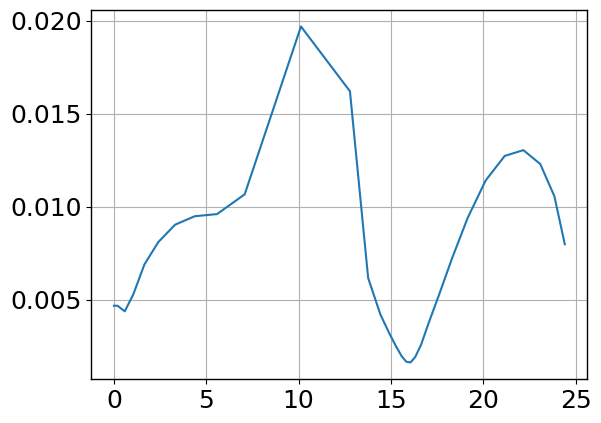

In [6]:
plt.plot(spar, profile['J']*case.ds['J'].conversion)

# 1D - 2D comparison

After running with reduced power in 1D, we can compare upstream sources

In [9]:
f_1D = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/02_eflow_da/m4ab-tune_albedo_1D_sep_add_1_case_02_include_flux_expansion')

/mnt/scratch/users/jlb647/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [ ]:
y = f_1D['y'][1:-1]

p_e_1d = replace_guards(np.ravel(f_1D['efe_tot_ylow'].isel(t=-1)))
p_d_1d = replace_guards(np.ravel(f_1D['efd+_tot_ylow'].isel(t=-1)))




# da = f_1D['dx']*f_1D['dz']*f_1D['J']/np.sqrt(f_1D['g_22'])
dx_1D_conv = f_1D['dx'].conversion  
da_1D = replace_guards(np.ravel(f_1D['dx']*dx_1D_conv*f_1D['dz']*f_1D['J']/np.sqrt(f_1D['g_22'])))

da = replace_guards(np.ravel(da))
# print(da)

q_e_1d = p_e_1d/da_1D
q_d_1d = p_d_1d/da_1D


q_paralell_e xpoint =  1.220804397593481
q_paralell_d xpoint =  0.4936017858523042


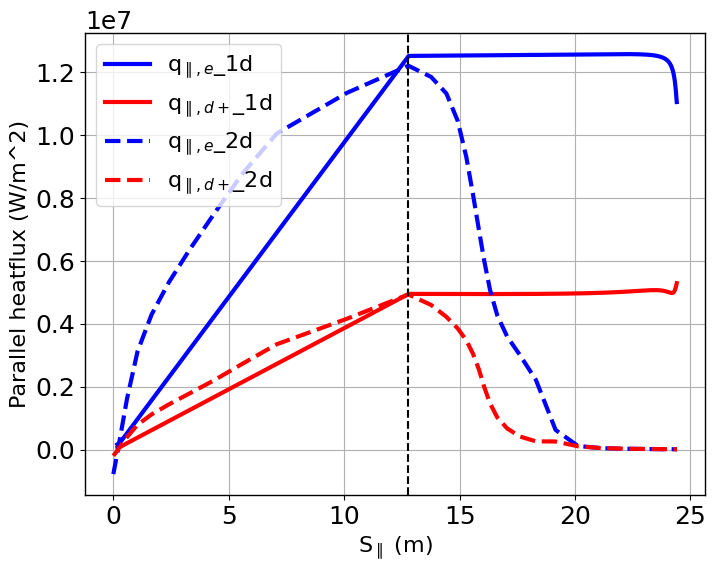

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,6))

# ax.plot(y, p_e_1d, label = 'p_e_1d', linewidth = linewidth, color='b')
# ax.plot(y, p_d_1d, label = 'p_d_1d', linewidth = linewidth, color = 'r')

print('q_paralell_e xpoint = ', np.max(heat_flux_e*1e-7))
print('q_paralell_d xpoint = ', np.max(heat_flux_d*1e-7))

ax.plot(y, q_e_1d, label = r'q$_{\parallel,e}$_1d', linewidth = linewidth, linestyle = '-', color = 'b')
ax.plot(y, q_d_1d, label = r'q$_{\parallel,d+}$_1d', linewidth = linewidth, linestyle = '-', color = 'r')
# ax.plot(spar ,profile['efe_tot_ylow'], label = 'p_e_2d', linewidth = linewidth, linestyle = '--', color = 'b')
# ax.plot(spar  ,profile['efd+_tot_ylow'], label = 'p_d_2d', linewidth = linewidth, linestyle = '--', color = 'r')
ax.plot(spar ,heat_flux_e, label = r'q$_{\parallel,e}$_2d', linewidth = linewidth, linestyle = '--', color = 'b')
ax.plot(spar  ,heat_flux_d, label = r'q$_{\parallel,d+}$_2d', linewidth = linewidth, linestyle = '--', color = 'r')
ax.axvline(spar[xpoint_loc], color = 'black', linestyle = '--')
ax.set_xlabel(r'S$_\parallel$ (m)')
ax.set_ylabel('Parallel heatflux (W/m^2)')
# ax.set_yscale('log')
plt.legend()


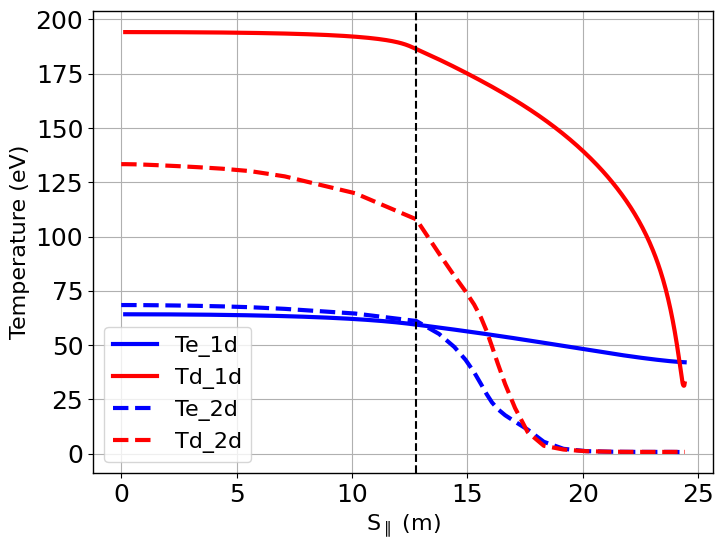

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
Te = replace_guards(np.ravel(f_1D['Te'].isel(t=-1)))
Td = replace_guards(np.ravel(f_1D['Td+'].isel(t=-1)))
ax.plot(y, Te, label = 'Te_1d', linewidth = linewidth, color='b')
ax.plot(y, Td, label = 'Td_1d', linewidth = linewidth, color = 'r')


ax.plot(spar, profile['Te'], label = 'Te_2d', linewidth = linewidth, linestyle = '--', color = 'b')
ax.plot(spar, profile['Td+'], label = 'Td_2d', linewidth = linewidth, linestyle = '--', color = 'r')
ax.axvline(spar[xpoint_loc], color = 'black', linestyle = '--')

ax.set_xlabel(r'S$_\parallel$ (m)')
ax.set_ylabel('Temperature (eV)')
ax.legend()


# cross field heat/partficle flow

extract

1 None
1


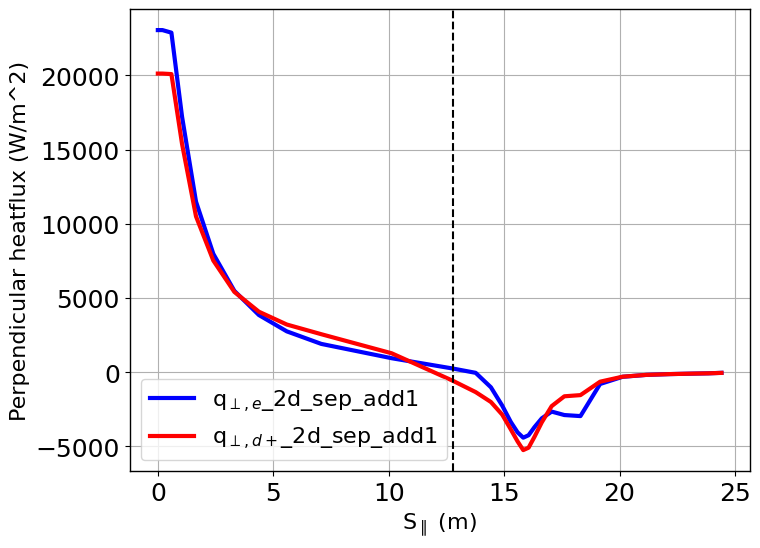

In [ ]:


params = ['R', 'Bxy', 'efd+_cond_ylow', 'efd+_kin_ylow', 'efd+_tot_xlow', 'efd+_tot_ylow', 
          'efe_cond_ylow' , 'efe_kin_ylow', 'efe_tot_ylow', 'kappa_par_e', 'Te', 
          'efd+_tot_xlow','efe_tot_xlow', 'J', 'g_22', 'dx', 'dy','dz', 'Td+', 'dr', 'dl', 'SNd+', 'SNd','pfd+_tot_xlow']

fig, ax = plt.subplots(1,1, figsize = (8,6))

for i in [1]:
    profile = get_1d_poloidal_data(case.ds.isel(t=-1), params = params, region = ('outer_lower'), sepadd = i)

    spar = profile['Spar']
    dy_conv = case.ds['dy'].conversion
    print(dy_conv)
    da_x_face = profile['dy']*profile['dz']
    da_x_face = profile['dl']*profile['dz']


    p_e_perp = profile['efe_tot_xlow']
    p_d_perp = profile['efd+_tot_xlow']

    q_e_perp = p_e_perp/da_x_face
    q_d_perp = p_d_perp/da_x_face


    # ax.plot(spar, p_e_perp, label = r'p$_{\perp,e}$_2d' + f'_sep_add{i}', linewidth = linewidth)
    # ax.plot(spar ,p_d_perp, label = r'p$_{\perp,d+}$_2d'+ f'_sep_add{i}', linewidth = linewidth)

    ax.plot(spar, q_e_perp, label = r'q$_{\perp,e}$_2d'+ f'_sep_add{i}', linewidth = linewidth, linestyle = '-', color = 'b')
    ax.plot(spar ,q_d_perp, label = r'q$_{\perp,d+}$_2d'+ f'_sep_add{i}', linewidth = linewidth, linestyle = '-', color = 'r')
ax.axvline(spar[xpoint_loc], color = 'black', linestyle = '--')

ax.set_xlabel(r'S$_\parallel$ (m)')
ax.set_ylabel('Perpendicular heatflux (W/m^2)')

ax.legend()

In [ ]:
print(case.ds.data_vars)

# print(case.ds['pfd+_tot_xlow'])

Data variables:
    Bxy                 (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    Dnnd                (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed+_iz              (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed+_rec             (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed_pump             (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed_target_recycle   (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed_target_refl      (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed_wall_recycle     (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Ed_wall_refl        (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Edd+_cx             (t, x, theta) float64 dask.array<chunksize=(6, 40, 108), meta=np.ndarray>
    Fd+_iz

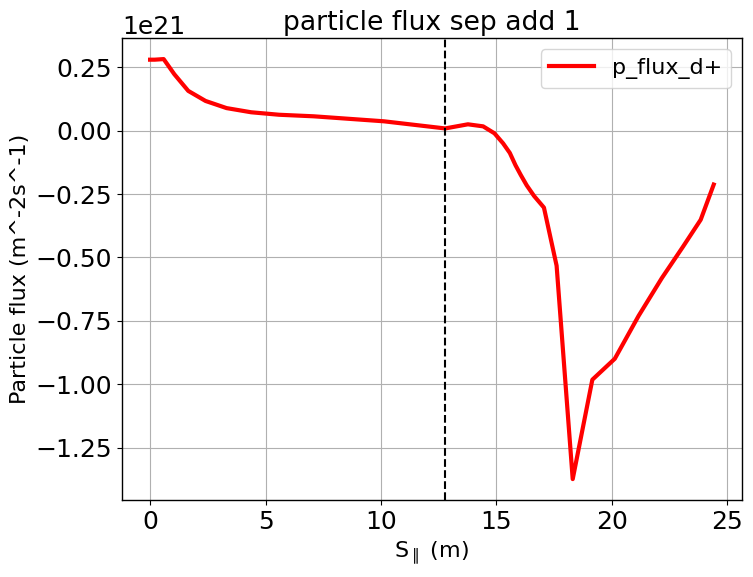

In [ ]:
flux_i = profile['pfd+_tot_xlow']/(profile['dl']*profile['dz'])
# flux_d = profile['pfd_tot_xlow']/(profile['dl']*profile['dz'])

fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(spar, flux_i, label = 'p_flux_d+', linewidth = linewidth, color= 'r')
# ax.plot(spar, flux_d, label = 'flux_d', linewidth = linewidth, color= 'g')

ax.axvline(spar[xpoint_loc], color = 'black', linestyle = '--')
ax.set_xlabel(r'S$_\parallel$ (m)')
ax.set_ylabel('Particle flux (m^-2s^-1)')
plt.title('particle flux sep add 1')

ax.legend()

## Geometry

0 None
1 None
5 None
10 None


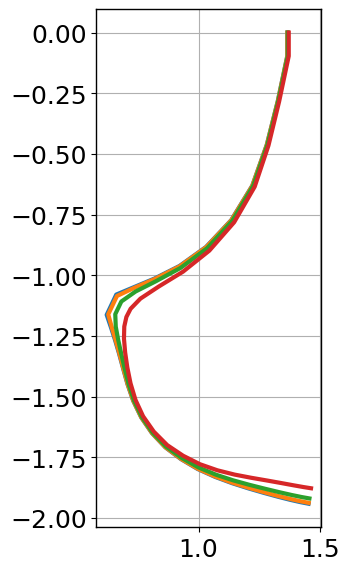

In [ ]:
params = ['R','Z', 'Bxy', 'efd+_cond_ylow', 'efd+_kin_ylow', 'efd+_tot_xlow', 'efd+_tot_ylow', 
          'efe_cond_ylow' , 'efe_kin_ylow', 'efe_tot_ylow', 'kappa_par_e', 'Te', 
          'efd+_tot_xlow','efe_tot_xlow', 'J', 'g_22', 'dx', 'dy','dz', 'Td+', 'dr', 'dl']

fig, ax = plt.subplots(1,1, figsize = (8,6))

for i in [0,1,5,10]:
    profile = get_1d_poloidal_data(case.ds.isel(t=-1), params = params, region = ('outer_lower'), sepadd = i)

    ax.plot(profile['R'], profile['Z'], label = f'sep_add{i}', linewidth = linewidth)
    ax.set_aspect('equal')
    fig.set_tight_layout(True)

    


# Energy and Particle balance

In [ ]:
params = ['R','Z', 'Bxy', 'efd+_cond_ylow', 'efd+_kin_ylow', 'efd+_tot_xlow', 'efd+_tot_ylow', 
          'efe_cond_ylow' , 'efe_kin_ylow', 'efe_tot_ylow', 'kappa_par_e', 'Te', 
          'efd+_tot_xlow','efe_tot_xlow', 'J', 'g_22', 'dx', 'dy','dz', 'Td+', 'dr', 'dl', 'dv']

profile = get_1d_poloidal_data(case.ds.isel(t=-1), params = params, region = ('outer_lower'), sepadd = 1)



1 None


In [ ]:
dx_1D_conv = f_1D['dx'].conversion  
da_y_face = np.ravel(f_1D['dx']*dx_1D_conv*f_1D['dz']*f_1D['J']/np.sqrt(f_1D['g_22']))

da_x_face = profile['dl']*profile['dz']

dv = profile['dv']


